In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:06<00:00, 27792894.69it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Neural Network Definition
class Nn(nn.Module):
    def __init__(self):
        super(Nn, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



net = Nn().to(device)


In [5]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [6]:
#  train and evaluating the model
def train_and_evaluate(model, criterion, optimizer, scheduler, trainloader, testloader, num_epochs=10):
    train_acc_history = []
    test_acc_history = []



    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_train = 0
        correct_train = 0




        for data in tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs} Training"):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        train_acc_history.append(train_accuracy)

        model.eval()
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for data in tqdm(testloader, desc=f"Epoch {epoch+1}/{num_epochs} Testing"):
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_accuracy = 100 * correct_test / total_test
        test_acc_history.append(test_accuracy)

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.3f}, Training Accuracy: {train_accuracy:.2f}%, Testing Accuracy: {test_accuracy:.2f}%')
        scheduler.step()



    # accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc_history, label='Training Accuracy')
    plt.plot(test_acc_history, label='Testing Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


Epoch 1/10 Training:   0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1/10 Testing: 100%|██████████| 100/100 [00:01<00:00, 70.65it/s]


Epoch 1, Loss: 1.490, Training Accuracy: 45.38%, Testing Accuracy: 57.57%


Epoch 2/10 Testing: 100%|██████████| 100/100 [00:01<00:00, 67.28it/s]


Epoch 2, Loss: 1.162, Training Accuracy: 58.16%, Testing Accuracy: 63.56%


Epoch 3/10 Testing: 100%|██████████| 100/100 [00:01<00:00, 69.51it/s]


Epoch 3, Loss: 1.027, Training Accuracy: 63.52%, Testing Accuracy: 67.79%


Epoch 4/10 Testing: 100%|██████████| 100/100 [00:01<00:00, 60.15it/s]


Epoch 4, Loss: 0.945, Training Accuracy: 66.46%, Testing Accuracy: 69.59%


Epoch 5/10 Testing: 100%|██████████| 100/100 [00:01<00:00, 72.43it/s]


Epoch 5, Loss: 0.879, Training Accuracy: 68.97%, Testing Accuracy: 69.71%


Epoch 6/10 Testing: 100%|██████████| 100/100 [00:01<00:00, 73.74it/s]


Epoch 6, Loss: 0.759, Training Accuracy: 73.52%, Testing Accuracy: 75.65%


Epoch 7/10 Testing: 100%|██████████| 100/100 [00:01<00:00, 69.29it/s]


Epoch 7, Loss: 0.725, Training Accuracy: 74.71%, Testing Accuracy: 75.99%


Epoch 8/10 Testing: 100%|██████████| 100/100 [00:01<00:00, 76.80it/s]


Epoch 8, Loss: 0.718, Training Accuracy: 75.08%, Testing Accuracy: 76.25%


Epoch 9/10 Testing: 100%|██████████| 100/100 [00:01<00:00, 70.28it/s]


Epoch 9, Loss: 0.702, Training Accuracy: 75.55%, Testing Accuracy: 76.19%


Epoch 10/10 Testing: 100%|██████████| 100/100 [00:01<00:00, 67.94it/s]


Epoch 10, Loss: 0.698, Training Accuracy: 75.67%, Testing Accuracy: 76.92%


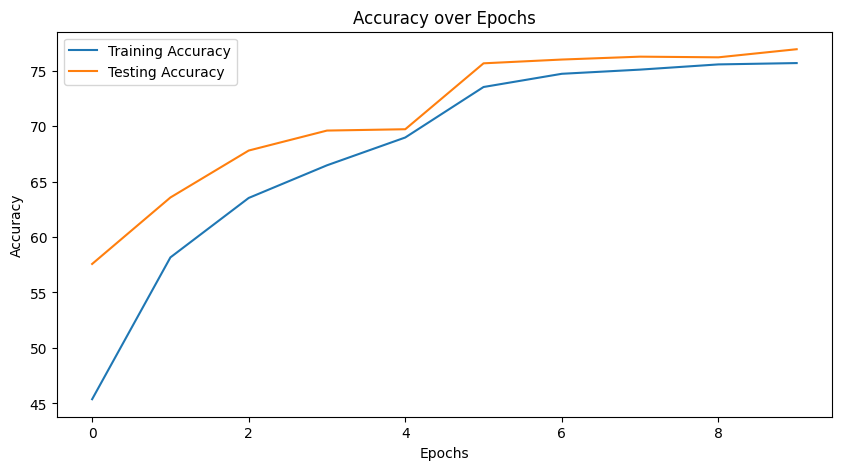

In [7]:

train_and_evaluate(net, criterion, optimizer, scheduler, trainloader, testloader, num_epochs=10)
